In [1]:
%load_ext autoreload
%autoreload 2

# Analyse the RBS data from Salis 2009

Thank you ScienceMachine :) 

Prompt: Using the Excel sheet named "Salis 2009" in the attached file, make a new sheet with the features "mRNA sequence", "Predicted dG_tot [kcal/mol]", "Average Fluorescence [au]", "Standard Deviation of Fluorescence [au]", "n", "Doubling Time [hours]", "Prediction #", "Log Average Fluorescence [au]", "Spacer Series #"

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import re
import os
from collections import Counter

from common import count_ARN_motifs, count_AAN_motifs, count_ARNn

In [3]:
fn = os.path.join('data', 'RBSCalculatorData.xlsx')
top_dir = os.path.join('data', '19_analyse_RBS_data_Salis')

In [4]:
# Read the Excel file
excel_file = pd.ExcelFile(fn)

# Read the Salis 2009 sheet
df = excel_file.parse('Salis 2009')

# Display the column names
print("Column names:")
print(df.columns.tolist())
print("\nShape of dataframe:", df.shape)

Column names:
['Supplementary Table I', 'Automated Design of Synthetic Ribosome Binding Sites to Precisely Control Protein Expression by Howard Salis, Ethan Mirsky, and Christopher Voigt', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8']

Shape of dataframe: (155, 9)


In [5]:
# Let's look at the first 20 rows to understand the structure
print("First 20 rows:")
for i in range(20):
    print(f"Row {i}: {df.iloc[i].tolist()}")

First 20 rows:
Row 0: ['Total number of RBSs: 132 (119 predictions)', nan, nan, nan, nan, nan, nan, nan, nan]
Row 1: ['Spacer Series (Figure S2)', 'mRNA sequence (containing the RBS and the beginning of the mRFP1 protein coding sequence, XbaI and SacI sites bolded)', 'Average Fluorescence [au] (n=5)', 'Standard Deviation of Fluorescence [au] (n=5)', 'dG_spacing [kcal/mol]', 'Predicted dG_tot [kcal/mol]', 'Spacer Series #', 'Log Average Fluorescence [au]', nan]
Row 2: ['s = 0', 'TTCTAGAAAAAAAATAAGGAGGTATGGCGAGCTCTGAAGACGTTATCAAAGAGTTCATGCGTTTCAAAGTTCGTATGGAA', 101.28, 54.34, 12.26, 4.104, 1, 4.617888958, nan]
Row 3: ['s = 1', 'TTCTAGAAAAAAAATAAGGAGGTAATGGCGAGCTCTGAAGACGTTATCAAAGAGTTCATGCGTTTCAAAGTTCGTATGGA', 133.59, 118.37, 11.7, 3.881, 2, 4.894775408, nan]
Row 4: ['s = 2', 'TTCTAGAAAAAAAATAAGGAGGTAAATGGCGAGCTCTGAAGACGTTATCAAAGAGTTCATGCGTTTCAAAGTTCGTATGG', 247.7, 119.81, 10.46, 1.554, 3, 5.512218336, nan]
Row 5: ['s = 3', 'TTCTAGAAAAAAAATAAGGAGGTAAAATGGCGAGCTCTGAAGACGTTATCAAAGAGTTCATGCG

In [6]:
# Read the Excel file again

# Read the Salis 2009 sheet
df = pd.read_excel(fn, sheet_name='Salis 2009', header=None)

# Initialize lists to store the data
data_rows = []

# Process the spacer series section (rows 2-14)
for i in range(2, 15):
    row = df.iloc[i]
    if pd.notna(row[1]):  # Check if mRNA sequence exists
        data_rows.append({
            'mRNA sequence': row[1],
            'Predicted dG_tot [kcal/mol]': row[5],
            'Average Fluorescence [au]': row[2],
            'Standard Deviation of Fluorescence [au]': row[3],
            'n': 5,  # n=5 for this section
            'Doubling Time [hours]': np.nan,  # Not available for this section
            'Prediction #': np.nan,  # Not available for this section
            'Log Average Fluorescence [au]': row[7],
            'Spacer Series #': row[6]
        })

print(f"Processed {len(data_rows)} rows from spacer series section")

Processed 13 rows from spacer series section


In [7]:
# Continue processing the reverse engineered RBS series (rows 17-24)
for i in range(17, 25):
    row = df.iloc[i]
    if pd.notna(row[1]) and row[1] != 'mRNA sequence (containing the RBS and the beginning of the mRFP1 protein coding sequence, XbaI and SacI sites bolded)':
        data_rows.append({
            'mRNA sequence': row[1],
            'Predicted dG_tot [kcal/mol]': row[2],
            'Average Fluorescence [au]': row[3],
            'Standard Deviation of Fluorescence [au]': row[4],
            'n': 6,  # n=6 for this section
            'Doubling Time [hours]': row[5],
            'Prediction #': row[7],
            'Log Average Fluorescence [au]': row[8],
            'Spacer Series #': np.nan  # Not available for this section
        })

print(f"Total rows after reverse engineered section: {len(data_rows)}")

Total rows after reverse engineered section: 20


In [8]:
# Continue processing the rest of the data
# Find where the next sections start
for i in range(25, len(df)):
    row = df.iloc[i]
    if pd.notna(row[1]) and isinstance(row[1], str) and len(row[1]) > 50:  # Likely an mRNA sequence
        # Check which format this row follows
        if pd.notna(row[2]) and pd.notna(row[3]) and pd.notna(row[4]):
            # This appears to be the format with Predicted dG_tot in column 2
            data_rows.append({
                'mRNA sequence': row[1],
                'Predicted dG_tot [kcal/mol]': row[2],
                'Average Fluorescence [au]': row[3],
                'Standard Deviation of Fluorescence [au]': row[4],
                'n': 6 if pd.notna(row[5]) else np.nan,
                'Doubling Time [hours]': row[5] if pd.notna(row[5]) else np.nan,
                'Prediction #': row[7] if pd.notna(row[7]) else np.nan,
                'Log Average Fluorescence [au]': row[8] if pd.notna(row[8]) else np.nan,
                'Spacer Series #': np.nan
            })

print(f"Total rows processed: {len(data_rows)}")

Total rows processed: 136


In [9]:
# Remove the header row that was accidentally included
data_rows = [row for row in data_rows if not row['mRNA sequence'].startswith('mRNA sequence')]

# Create a DataFrame from the collected data
result_df = pd.DataFrame(data_rows)

# Reorder columns as requested
columns_order = [
    'mRNA sequence',
    'Predicted dG_tot [kcal/mol]',
    'Average Fluorescence [au]',
    'Standard Deviation of Fluorescence [au]',
    'n',
    'Doubling Time [hours]',
    'Prediction #',
    'Log Average Fluorescence [au]',
    'Spacer Series #'
]

result_df = result_df[columns_order]

print(f"Final dataframe shape: {result_df.shape}")

Final dataframe shape: (131, 9)


In [10]:
# Now save this to a new Excel file with the extracted data
with pd.ExcelWriter('RBSCalculatorData_Extracted.xlsx', engine='openpyxl') as writer:
    result_df.to_excel(writer, sheet_name='Salis 2009 Extracted', index=False)

print("New Excel file created: RBSCalculatorData_Extracted.xlsx")
print(f"\nTotal number of rows extracted: {len(result_df)}")
print("\nColumn summary:")
for col in columns_order:
    non_null = result_df[col].notna().sum()
    print(f"  {col}: {non_null} non-null values")

New Excel file created: RBSCalculatorData_Extracted.xlsx

Total number of rows extracted: 131

Column summary:
  mRNA sequence: 131 non-null values
  Predicted dG_tot [kcal/mol]: 131 non-null values
  Average Fluorescence [au]: 131 non-null values
  Standard Deviation of Fluorescence [au]: 131 non-null values
  n: 131 non-null values
  Doubling Time [hours]: 119 non-null values
  Prediction #: 119 non-null values
  Log Average Fluorescence [au]: 131 non-null values
  Spacer Series #: 12 non-null values


In [11]:
# Show sample rows from different sections
print("Sample rows from the extracted data:\n")

print("First 3 rows (Spacer Series):")
print(result_df.head(3).to_string())

print("\n\nRows 13-16 (Reverse engineered RBS series):")
print(result_df.iloc[13:16].to_string())

print("\n\nRows 100-103 (Later sections):")
print(result_df.iloc[100:103].to_string())

Sample rows from the extracted data:

First 3 rows (Spacer Series):
                                                                      mRNA sequence  Predicted dG_tot [kcal/mol]  Average Fluorescence [au]  Standard Deviation of Fluorescence [au]  n  Doubling Time [hours]  Prediction #  Log Average Fluorescence [au]  Spacer Series #
0  TTCTAGAAAAAAAATAAGGAGGTATGGCGAGCTCTGAAGACGTTATCAAAGAGTTCATGCGTTTCAAAGTTCGTATGGAA                        4.104                     101.28                                    54.34  5                    NaN           NaN                       4.617889              1.0
1  TTCTAGAAAAAAAATAAGGAGGTAATGGCGAGCTCTGAAGACGTTATCAAAGAGTTCATGCGTTTCAAAGTTCGTATGGA                        3.881                     133.59                                   118.37  5                    NaN           NaN                       4.894775              2.0
2  TTCTAGAAAAAAAATAAGGAGGTAAATGGCGAGCTCTGAAGACGTTATCAAAGAGTTCATGCGTTTCAAAGTTCGTATGG                        1.554             

# Add the ARN motif

Prompt: For the "mRNA sequence" column in the "RBSCalculatorData_Extracted.xlsx" file, count how many time the motif "ARN" comes up, where A = A, R = A or G, and N = any nucleotide letter.

In [23]:

# Read the extracted Excel file
df = pd.read_excel('RBSCalculatorData_Extracted.xlsx', sheet_name='Salis 2009 Extracted')

# Count motifs in each sequence
df['ARN_count'] = df['mRNA sequence'].apply(count_ARN_motifs)
df['AAN_count'] = df['mRNA sequence'].apply(count_AAN_motifs)
df['ARNn_count'] = df['mRNA sequence'].apply(count_ARNn)

# Get total count across all sequences
total_ARN_count = df['ARN_count'].sum()
total_AAN_count = df['AAN_count'].sum()
total_ARNn_count = df['ARNn_count'].sum()

print(f"Total number of ARN motifs across all sequences: {total_ARN_count}")
print(f"Total number of AAN motifs across all sequences: {total_AAN_count}")
print(f"\nNumber of sequences analyzed: {len(df)}")
print(f"Average ARN motifs per sequence: {total_ARN_count / len(df):.2f}")
print(f"Average AAN motifs per sequence: {total_AAN_count / len(df):.2f}")

# Show distribution of ARN counts
print("\nDistribution of ARN motifs per sequence:")
print(df['ARN_count'].value_counts().sort_index())

# Show distribution of AAN counts
print("\nDistribution of AAN motifs per sequence:")
print(df['AAN_count'].value_counts().sort_index())

Total number of ARN motifs across all sequences: 1339
Total number of AAN motifs across all sequences: 806

Number of sequences analyzed: 131
Average ARN motifs per sequence: 10.22
Average AAN motifs per sequence: 6.15

Distribution of ARN motifs per sequence:
ARN_count
7      6
8     12
9     33
10    28
11    24
12    13
13     8
14     5
15     2
Name: count, dtype: int64

Distribution of AAN motifs per sequence:
AAN_count
3      3
4     15
5     36
6     26
7     27
8     11
9      8
10     3
11     2
Name: count, dtype: int64


In [13]:
# Let's examine a few sequences and their ARN motifs
print("Examples of ARN motifs found in sequences:\n")

# Take first 3 sequences as examples
for i in range(3):
    sequence = df.iloc[i]['mRNA sequence']
    pattern = r'A[AG][ACGT]'
    matches = re.findall(pattern, sequence.upper())
    
    print(f"Sequence {i+1} (first 50 chars): {sequence[:50]}...")
    print(f"ARN motifs found: {matches}")
    print(f"Count: {len(matches)}\n")

# Also check which specific ARN patterns are most common
print("\nBreakdown of specific ARN patterns found:")
all_matches = []
for sequence in df['mRNA sequence']:
    matches = re.findall(r'A[AG][ACGT]', sequence.upper())
    all_matches.extend(matches)

pattern_counts = Counter(all_matches)
for pattern, count in sorted(pattern_counts.items(), key=lambda x: -x[1]):
    print(f"{pattern}: {count} occurrences")

Examples of ARN motifs found in sequences:

Sequence 1 (first 50 chars): TTCTAGAAAAAAAATAAGGAGGTATGGCGAGCTCTGAAGACGTTATCAAA...
ARN motifs found: ['AGA', 'AAA', 'AAA', 'AAG', 'AGG', 'AGC', 'AAG', 'AAA', 'AGT', 'AAA']
Count: 10

Sequence 2 (first 50 chars): TTCTAGAAAAAAAATAAGGAGGTAATGGCGAGCTCTGAAGACGTTATCAA...
ARN motifs found: ['AGA', 'AAA', 'AAA', 'AAG', 'AGG', 'AAT', 'AGC', 'AAG', 'AAA', 'AGT', 'AAA']
Count: 11

Sequence 3 (first 50 chars): TTCTAGAAAAAAAATAAGGAGGTAAATGGCGAGCTCTGAAGACGTTATCA...
ARN motifs found: ['AGA', 'AAA', 'AAA', 'AAG', 'AGG', 'AAA', 'AGC', 'AAG', 'AAA', 'AGT', 'AAA']
Count: 11


Breakdown of specific ARN patterns found:
AAA: 377 occurrences
AAG: 260 occurrences
AGA: 211 occurrences
AGC: 148 occurrences
AGT: 138 occurrences
AGG: 99 occurrences
AAT: 69 occurrences
AAC: 37 occurrences


The ARN motif (where A=A, R=A or G, and N=any nucleotide) appears 1,339 times total across all 131 mRNA sequences in the extracted data.

Key findings:

Total occurrences: 1,339 ARN motifs
Average per sequence: 10.22 motifs
Range: 7 to 15 motifs per sequence
Most common count: 9 motifs per sequence (found in 33 sequences)
The specific ARN patterns found were:

AAA: 377 occurrences (most common)
AAG: 260 occurrences
AGA: 211 occurrences
AGC: 148 occurrences
AGT: 138 occurrences
AGG: 99 occurrences
AAT: 69 occurrences
AAC: 37 occurrences (least common)
All patterns correctly match the motif definition where the first position is A, the second position is either A or G (purine), and the third position can be any nucleotide (A, C, G, or T).

# ARN motifs correlating with DG

Prompt: Plot how the number of ARN motifs in the sequence correlates with the "Predicted dG_tot [kcal/mol]"

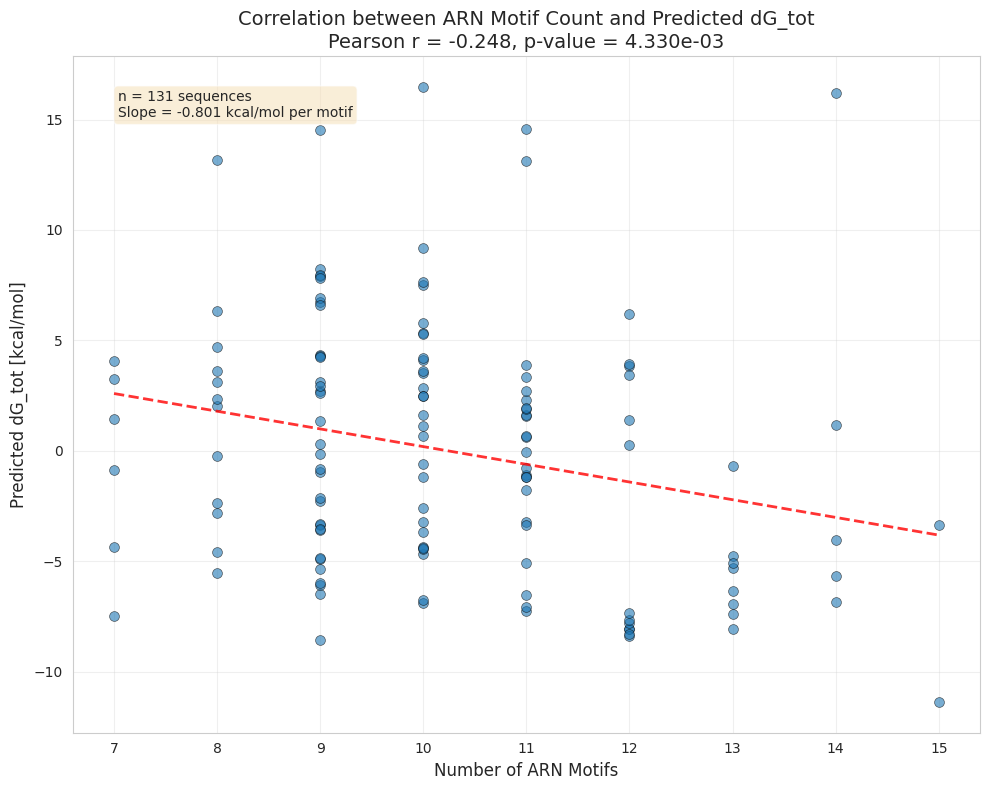

Correlation coefficient (Pearson r): -0.2477
P-value: 4.3301e-03
R-squared: 0.0614

Linear regression equation: dG_tot = -0.801 × (ARN count) + 8.201


In [14]:
# Set up the plot style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Create scatter plot
plt.scatter(df['ARN_count'], df['Predicted dG_tot [kcal/mol]'], 
            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Calculate correlation
correlation = df['ARN_count'].corr(df['Predicted dG_tot [kcal/mol]'])
pearson_r, p_value = stats.pearsonr(df['ARN_count'], df['Predicted dG_tot [kcal/mol]'])

# Add trend line
z = np.polyfit(df['ARN_count'], df['Predicted dG_tot [kcal/mol]'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df['ARN_count'].min(), df['ARN_count'].max(), 100)
plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label=f'Linear fit')

# Labels and title
plt.xlabel('Number of ARN Motifs', fontsize=12)
plt.ylabel('Predicted dG_tot [kcal/mol]', fontsize=12)
plt.title('Correlation between ARN Motif Count and Predicted dG_tot\n' + 
          f'Pearson r = {correlation:.3f}, p-value = {p_value:.3e}', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3)

# Add text box with statistics
textstr = f'n = {len(df)} sequences\nSlope = {z[0]:.3f} kcal/mol per motif'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'ARN_motif_vs_dG_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print additional statistics
print(f"Correlation coefficient (Pearson r): {correlation:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"R-squared: {correlation**2:.4f}")
print(f"\nLinear regression equation: dG_tot = {z[0]:.3f} × (ARN count) + {z[1]:.3f}")

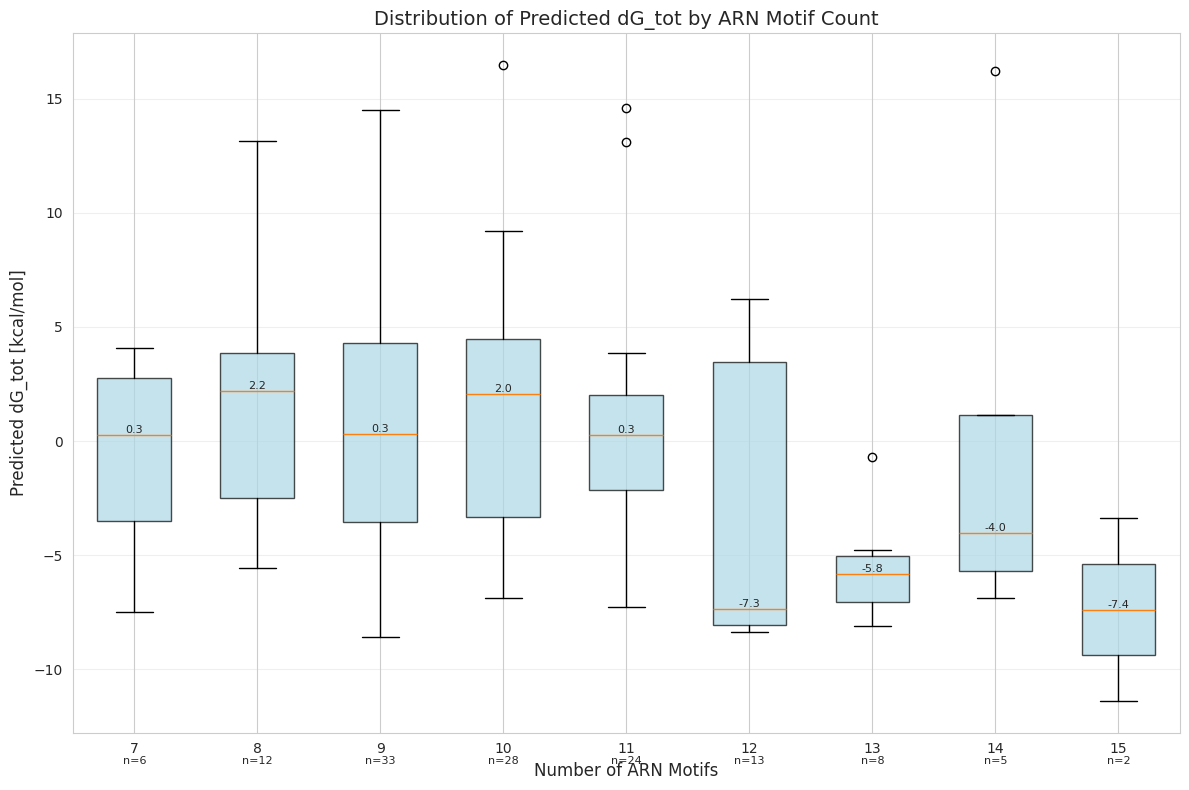


Summary statistics by ARN motif count:
ARN Count | n | Mean dG_tot | Median dG_tot | Std Dev
-------------------------------------------------------
        7 |  6 |       -0.67 |          0.28 |    4.53
        8 | 12 |        1.64 |          2.17 |    5.23
        9 | 33 |        0.91 |          0.32 |    5.56
       10 | 28 |        1.46 |          2.04 |    5.41
       11 | 24 |        0.40 |          0.29 |    5.25
       12 | 13 |       -2.81 |         -7.35 |    5.93
       13 |  8 |       -5.58 |         -5.83 |    2.30
       14 |  5 |        0.16 |         -4.04 |    9.48
       15 |  2 |       -7.38 |         -7.38 |    5.66


In [15]:
# Create a box plot
plt.figure(figsize=(12, 8))

# Create box plot
box_plot = plt.boxplot([df[df['ARN_count'] == count]['Predicted dG_tot [kcal/mol]'].values 
                        for count in sorted(df['ARN_count'].unique())],
                       positions=sorted(df['ARN_count'].unique()),
                       widths=0.6,
                       patch_artist=True,
                       showfliers=True)

# Customize box plot colors
for patch in box_plot['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# Add median values as text
for i, count in enumerate(sorted(df['ARN_count'].unique())):
    median_val = df[df['ARN_count'] == count]['Predicted dG_tot [kcal/mol]'].median()
    n_samples = len(df[df['ARN_count'] == count])
    plt.text(count, median_val, f'{median_val:.1f}', 
             horizontalalignment='center', verticalalignment='bottom', fontsize=8)
    # Add sample size below x-axis
    plt.text(count, plt.ylim()[0] - 1, f'n={n_samples}', 
             horizontalalignment='center', verticalalignment='top', fontsize=8)

# Labels and title
plt.xlabel('Number of ARN Motifs', fontsize=12)
plt.ylabel('Predicted dG_tot [kcal/mol]', fontsize=12)
plt.title('Distribution of Predicted dG_tot by ARN Motif Count', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3, axis='y')

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'ARN_motif_vs_dG_boxplot.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print summary statistics
print("\nSummary statistics by ARN motif count:")
print("ARN Count | n | Mean dG_tot | Median dG_tot | Std Dev")
print("-" * 55)
for count in sorted(df['ARN_count'].unique()):
    subset = df[df['ARN_count'] == count]['Predicted dG_tot [kcal/mol]']
    print(f"{count:9d} | {len(subset):2d} | {subset.mean():11.2f} | {subset.median():13.2f} | {subset.std():7.2f}")

# ARN motifs vs. fluorescence

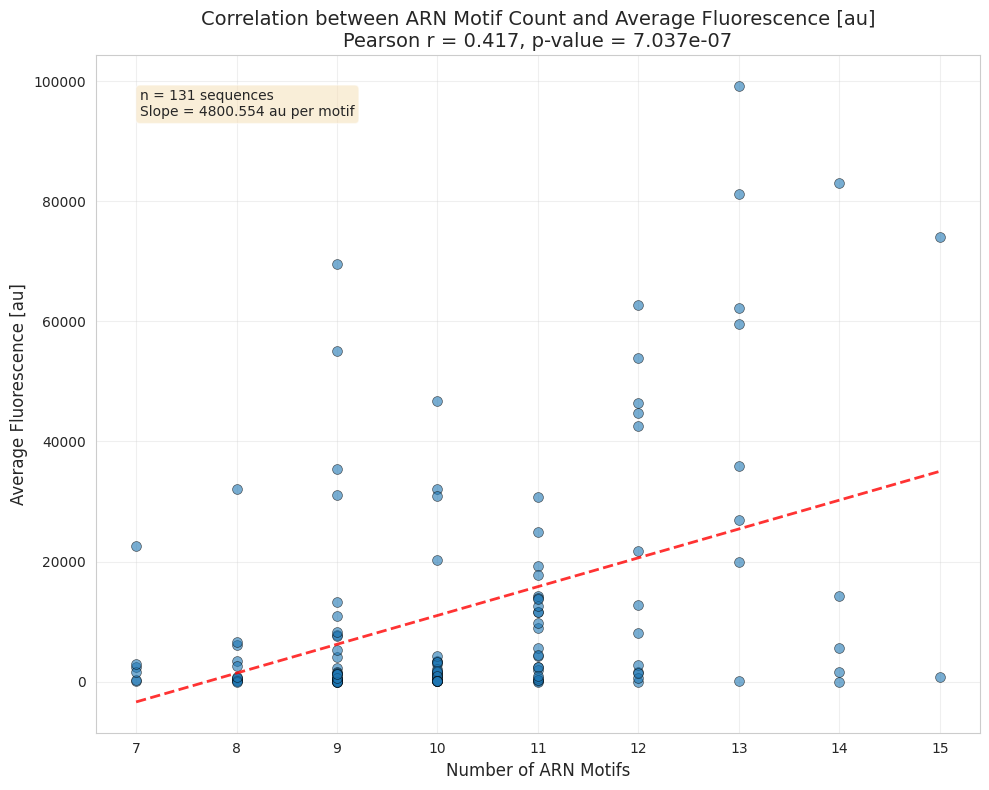

Correlation coefficient (Pearson r): 0.4174
P-value: 7.0373e-07
R-squared: 0.1743

Linear regression equation: Fluorescence = 4800.554 × (ARN count) + -36986.664


In [16]:
# Set up the plot style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Create scatter plot
plt.scatter(df['ARN_count'], df['Average Fluorescence [au]'], 
            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Calculate correlation
correlation = df['ARN_count'].corr(df['Average Fluorescence [au]'])
pearson_r, p_value = stats.pearsonr(df['ARN_count'], df['Average Fluorescence [au]'])

# Add trend line
z = np.polyfit(df['ARN_count'], df['Average Fluorescence [au]'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df['ARN_count'].min(), df['ARN_count'].max(), 100)
plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label=f'Linear fit')

# Labels and title
plt.xlabel('Number of ARN Motifs', fontsize=12)
plt.ylabel('Average Fluorescence [au]', fontsize=12)
plt.title('Correlation between ARN Motif Count and Average Fluorescence [au]\n' + 
          f'Pearson r = {correlation:.3f}, p-value = {p_value:.3e}', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3)

# Add text box with statistics
textstr = f'n = {len(df)} sequences\nSlope = {z[0]:.3f} au per motif'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'ARN_motif_vs_fluorescence_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print additional statistics
print(f"Correlation coefficient (Pearson r): {correlation:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"R-squared: {correlation**2:.4f}")
print(f"\nLinear regression equation: Fluorescence = {z[0]:.3f} × (ARN count) + {z[1]:.3f}")

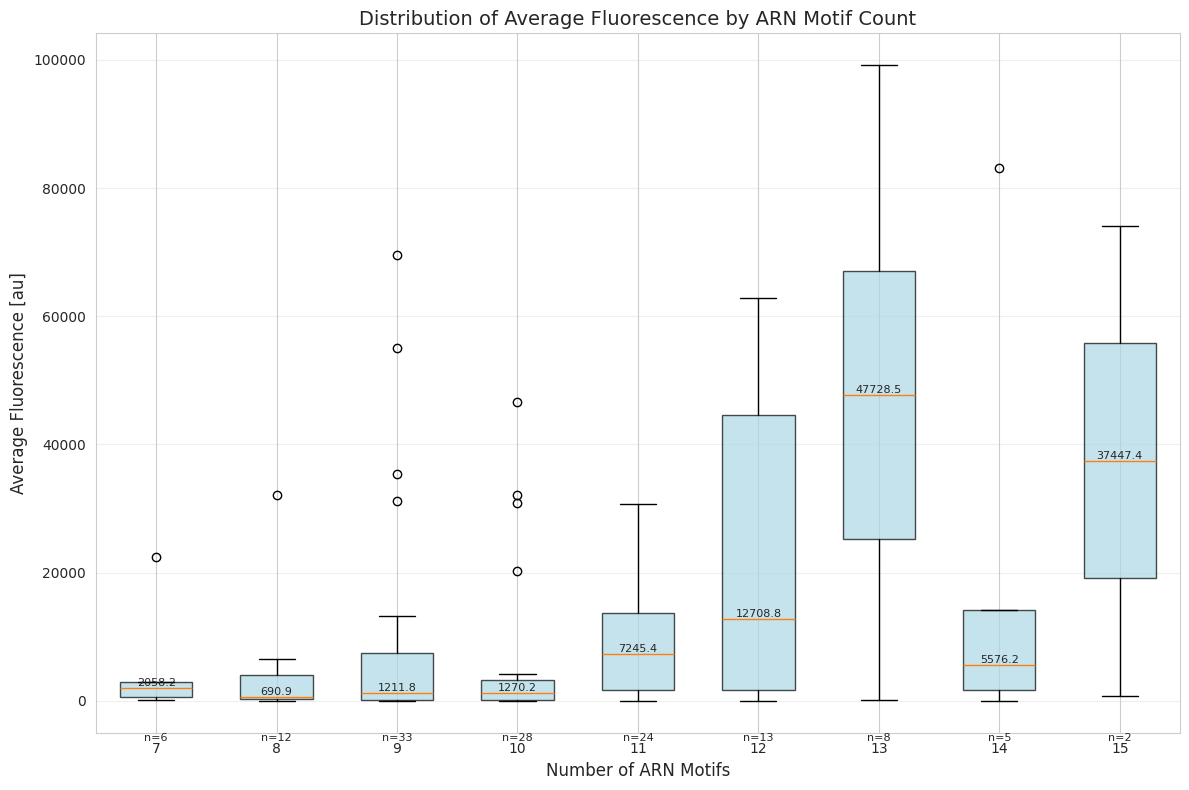


Summary statistics by ARN motif count:
ARN Count | n | Mean Fluorescence | Median Fluorescence | Std Dev
-------------------------------------------------------
        7 |  6 |     5010.22 |       2058.22 | 8656.82
        8 | 12 |     4437.24 |        690.86 | 9009.86
        9 | 33 |     7914.22 |       1211.81 | 16358.10
       10 | 28 |     5761.70 |       1270.16 | 11743.87
       11 | 24 |     8863.66 |       7245.38 | 8445.71
       12 | 13 |    23044.51 |      12708.84 | 23501.90
       13 |  8 |    48133.37 |      47728.52 | 33235.34
       14 |  5 |    20923.15 |       5576.24 | 35186.47
       15 |  2 |    37447.42 |      37447.42 | 51817.81


In [17]:
# Create a box plot
plt.figure(figsize=(12, 8))

# Create box plot
box_plot = plt.boxplot([df[df['ARN_count'] == count]['Average Fluorescence [au]'].values 
                        for count in sorted(df['ARN_count'].unique())],
                       positions=sorted(df['ARN_count'].unique()),
                       widths=0.6,
                       patch_artist=True,
                       showfliers=True)

# Customize box plot colors
for patch in box_plot['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# Add median values as text
for i, count in enumerate(sorted(df['ARN_count'].unique())):
    median_val = df[df['ARN_count'] == count]['Average Fluorescence [au]'].median()
    n_samples = len(df[df['ARN_count'] == count])
    plt.text(count, median_val, f'{median_val:.1f}', 
             horizontalalignment='center', verticalalignment='bottom', fontsize=8)
    # Add sample size below x-axis
    plt.text(count, plt.ylim()[0] - 1, f'n={n_samples}', 
             horizontalalignment='center', verticalalignment='top', fontsize=8)

# Labels and title
plt.xlabel('Number of ARN Motifs', fontsize=12)
plt.ylabel('Average Fluorescence [au]', fontsize=12)
plt.title('Distribution of Average Fluorescence by ARN Motif Count', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3, axis='y')

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'ARN_motif_vs_fluorescence_boxplot.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print summary statistics
print("\nSummary statistics by ARN motif count:")
print("ARN Count | n | Mean Fluorescence | Median Fluorescence | Std Dev")
print("-" * 55)
for count in sorted(df['ARN_count'].unique()):
    subset = df[df['ARN_count'] == count]['Average Fluorescence [au]']
    print(f"{count:9d} | {len(subset):2d} | {subset.mean():11.2f} | {subset.median():13.2f} | {subset.std():7.2f}")

# Now the same but only for (ARN)n motifs

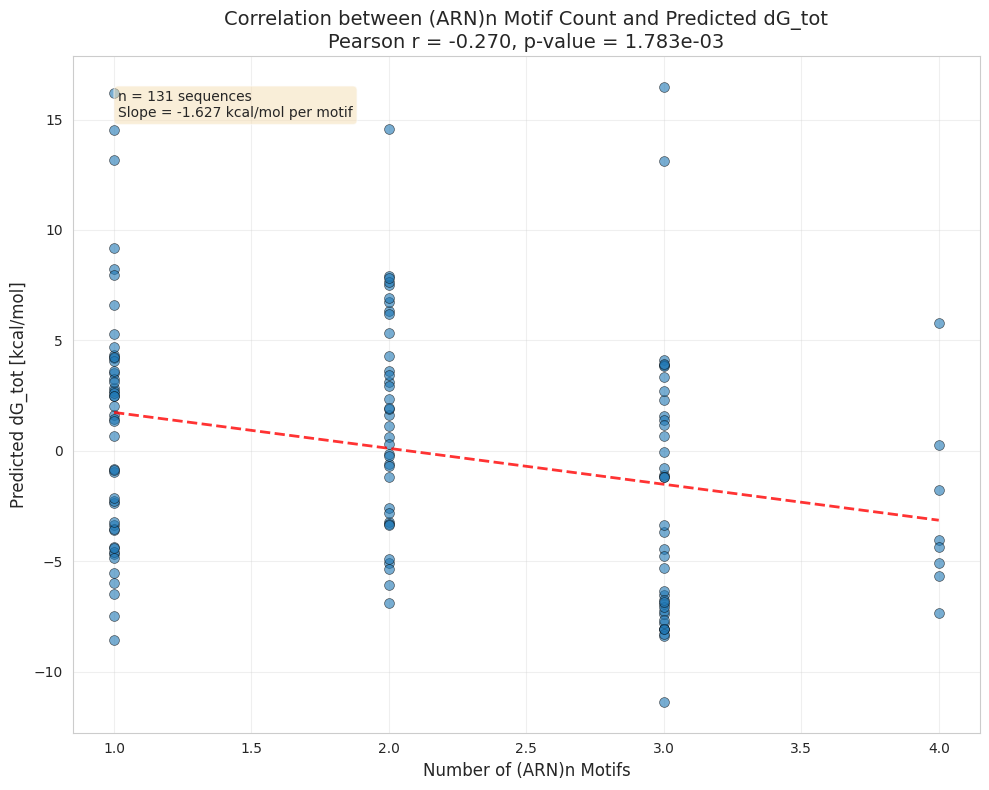

Correlation coefficient (Pearson r): -0.2704
P-value: 1.7829e-03
R-squared: 0.0731

Linear regression equation: dG_tot = -1.627 × (ARN count) + 3.363


In [24]:
# Set up the plot style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Create scatter plot
plt.scatter(df['ARNn_count'], df['Predicted dG_tot [kcal/mol]'], 
            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Calculate correlation
correlation = df['ARNn_count'].corr(df['Predicted dG_tot [kcal/mol]'])
pearson_r, p_value = stats.pearsonr(df['ARNn_count'], df['Predicted dG_tot [kcal/mol]'])

# Add trend line
z = np.polyfit(df['ARNn_count'], df['Predicted dG_tot [kcal/mol]'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df['ARNn_count'].min(), df['ARNn_count'].max(), 100)
plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label=f'Linear fit')

# Labels and title
plt.xlabel('Number of (ARN)n Motifs', fontsize=12)
plt.ylabel('Predicted dG_tot [kcal/mol]', fontsize=12)
plt.title('Correlation between (ARN)n Motif Count and Predicted dG_tot\n' + 
          f'Pearson r = {correlation:.3f}, p-value = {p_value:.3e}', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3)

# Add text box with statistics
textstr = f'n = {len(df)} sequences\nSlope = {z[0]:.3f} kcal/mol per motif'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'ARNn_motif_vs_dG_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print additional statistics
print(f"Correlation coefficient (Pearson r): {correlation:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"R-squared: {correlation**2:.4f}")
print(f"\nLinear regression equation: dG_tot = {z[0]:.3f} × (ARN count) + {z[1]:.3f}")

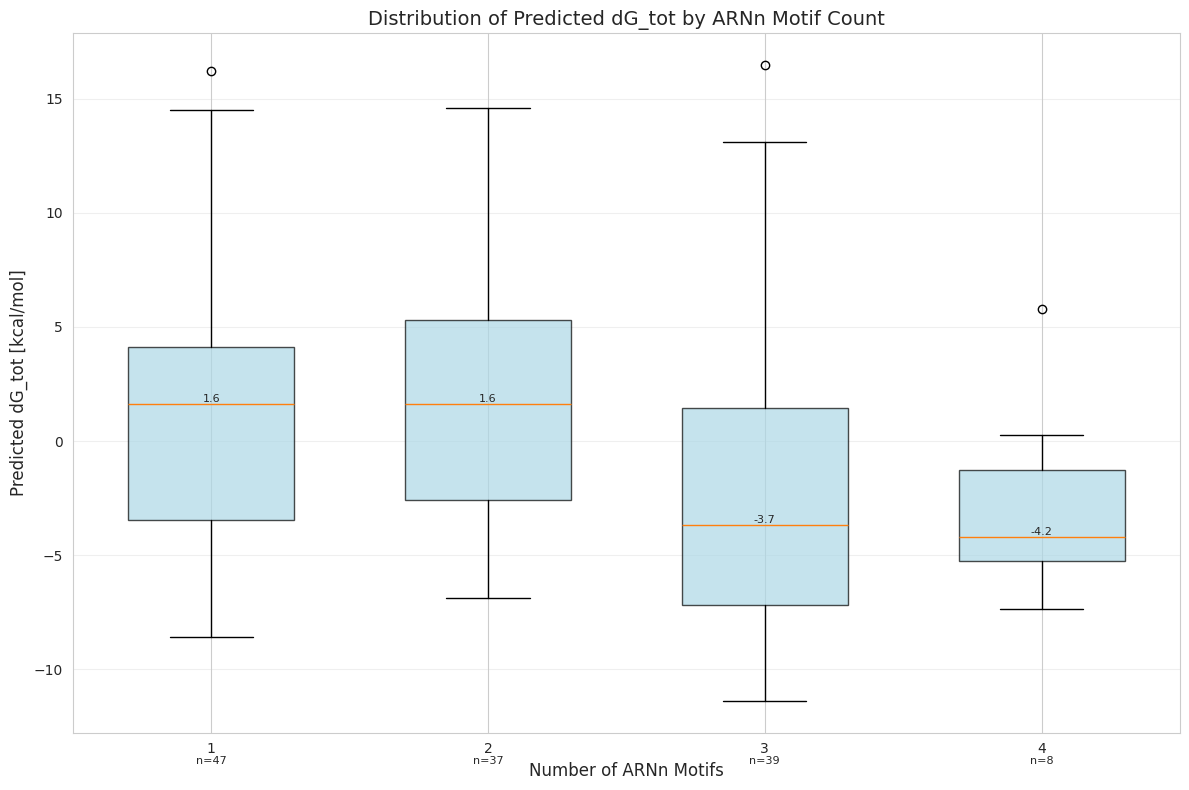


Summary statistics by ARNn motif count:
ARNn Count | n | Mean dG_tot | Median dG_tot | Std Dev
-------------------------------------------------------
        1 | 47 |        1.20 |          1.63 |    5.63
        2 | 37 |        1.56 |          1.62 |    4.87
        3 | 39 |       -2.32 |         -3.68 |    6.05
        4 |  8 |       -2.78 |         -4.21 |    4.19


In [25]:
# Create a box plot
plt.figure(figsize=(12, 8))

# Create box plot
box_plot = plt.boxplot([df[df['ARNn_count'] == count]['Predicted dG_tot [kcal/mol]'].values 
                        for count in sorted(df['ARNn_count'].unique())],
                       positions=sorted(df['ARNn_count'].unique()),
                       widths=0.6,
                       patch_artist=True,
                       showfliers=True)

# Customize box plot colors
for patch in box_plot['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# Add median values as text
for i, count in enumerate(sorted(df['ARNn_count'].unique())):
    median_val = df[df['ARNn_count'] == count]['Predicted dG_tot [kcal/mol]'].median()
    n_samples = len(df[df['ARNn_count'] == count])
    plt.text(count, median_val, f'{median_val:.1f}', 
             horizontalalignment='center', verticalalignment='bottom', fontsize=8)
    # Add sample size below x-axis
    plt.text(count, plt.ylim()[0] - 1, f'n={n_samples}', 
             horizontalalignment='center', verticalalignment='top', fontsize=8)

# Labels and title
plt.xlabel('Number of ARNn Motifs', fontsize=12)
plt.ylabel('Predicted dG_tot [kcal/mol]', fontsize=12)
plt.title('Distribution of Predicted dG_tot by ARNn Motif Count', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3, axis='y')

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'ARNn_motif_vs_dG_boxplot.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print summary statistics
print("\nSummary statistics by ARNn motif count:")
print("ARNn Count | n | Mean dG_tot | Median dG_tot | Std Dev")
print("-" * 55)
for count in sorted(df['ARNn_count'].unique()):
    subset = df[df['ARNn_count'] == count]['Predicted dG_tot [kcal/mol]']
    print(f"{count:9d} | {len(subset):2d} | {subset.mean():11.2f} | {subset.median():13.2f} | {subset.std():7.2f}")

# AAN motif but fluorescence

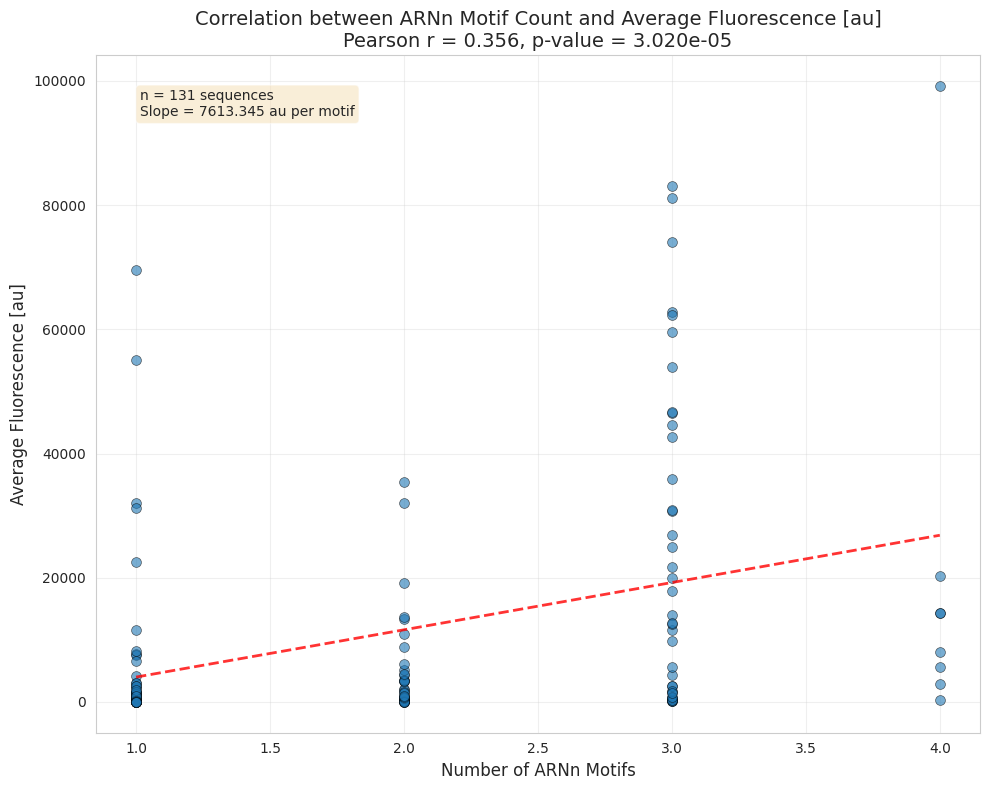

Correlation coefficient (Pearson r): 0.3559
P-value: 3.0198e-05
R-squared: 0.1267

Linear regression equation: Fluorescence = 7613.345 × (ARNn count) + -3610.032


In [26]:
# Set up the plot style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Create scatter plot
plt.scatter(df['ARNn_count'], df['Average Fluorescence [au]'], 
            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Calculate correlation
correlation = df['ARNn_count'].corr(df['Average Fluorescence [au]'])
pearson_r, p_value = stats.pearsonr(df['ARNn_count'], df['Average Fluorescence [au]'])

# Add trend line
z = np.polyfit(df['ARNn_count'], df['Average Fluorescence [au]'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df['ARNn_count'].min(), df['ARNn_count'].max(), 100)
plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label=f'Linear fit')

# Labels and title
plt.xlabel('Number of ARNn Motifs', fontsize=12)
plt.ylabel('Average Fluorescence [au]', fontsize=12)
plt.title('Correlation between ARNn Motif Count and Average Fluorescence [au]\n' + 
          f'Pearson r = {correlation:.3f}, p-value = {p_value:.3e}', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3)

# Add text box with statistics
textstr = f'n = {len(df)} sequences\nSlope = {z[0]:.3f} au per motif'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'ARNn_motif_vs_fluorescence_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print additional statistics
print(f"Correlation coefficient (Pearson r): {correlation:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"R-squared: {correlation**2:.4f}")
print(f"\nLinear regression equation: Fluorescence = {z[0]:.3f} × (ARNn count) + {z[1]:.3f}")

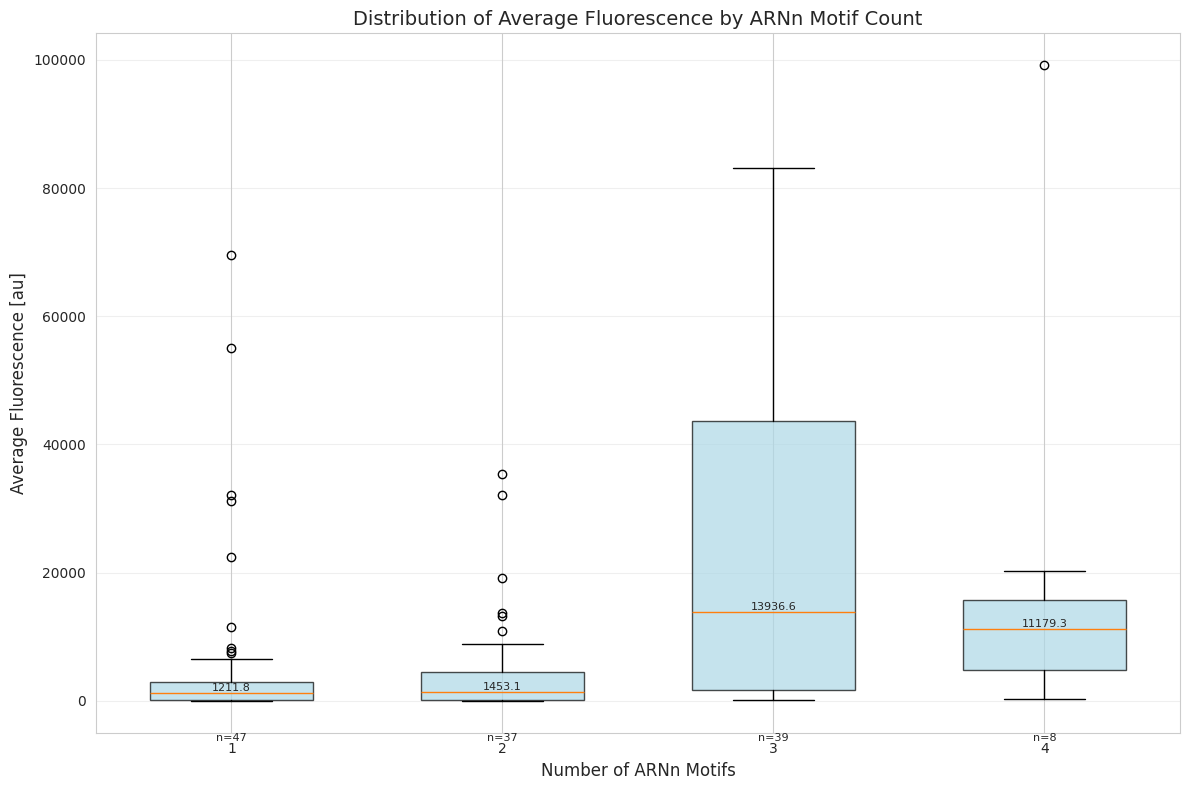


Summary statistics by ARNn motif count:
ARNn Count | n | Mean Fluorescence | Median Fluorescence | Std Dev
-------------------------------------------------------
        1 | 47 |     6122.52 |       1211.81 | 14021.20
        2 | 37 |     4880.31 |       1453.09 | 8331.48
        3 | 39 |    24350.05 |      13936.57 | 25559.95
        4 |  8 |    20588.41 |      11179.28 | 32440.85


In [27]:
# Create a box plot
plt.figure(figsize=(12, 8))

# Create box plot
box_plot = plt.boxplot([df[df['ARNn_count'] == count]['Average Fluorescence [au]'].values 
                        for count in sorted(df['ARNn_count'].unique())],
                       positions=sorted(df['ARNn_count'].unique()),
                       widths=0.6,
                       patch_artist=True,
                       showfliers=True)

# Customize box plot colors
for patch in box_plot['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# Add median values as text
for i, count in enumerate(sorted(df['ARNn_count'].unique())):
    median_val = df[df['ARNn_count'] == count]['Average Fluorescence [au]'].median()
    n_samples = len(df[df['ARNn_count'] == count])
    plt.text(count, median_val, f'{median_val:.1f}', 
             horizontalalignment='center', verticalalignment='bottom', fontsize=8)
    # Add sample size below x-axis
    plt.text(count, plt.ylim()[0] - 1, f'n={n_samples}', 
             horizontalalignment='center', verticalalignment='top', fontsize=8)

# Labels and title
plt.xlabel('Number of ARNn Motifs', fontsize=12)
plt.ylabel('Average Fluorescence [au]', fontsize=12)
plt.title('Distribution of Average Fluorescence by ARNn Motif Count', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3, axis='y')

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'ARNn_motif_vs_fluorescence_boxplot.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print summary statistics
print("\nSummary statistics by ARNn motif count:")
print("ARNn Count | n | Mean Fluorescence | Median Fluorescence | Std Dev")
print("-" * 55)
for count in sorted(df['ARNn_count'].unique()):
    subset = df[df['ARNn_count'] == count]['Average Fluorescence [au]']
    print(f"{count:9d} | {len(subset):2d} | {subset.mean():11.2f} | {subset.median():13.2f} | {subset.std():7.2f}")